# DeepLabCut Speed Calculation

A Jupyter notebook to load DeepLabCut CSV output and calculate mouse speed based on tracked body parts.

## Setup Environment and Variables

Import necessary libraries (pandas, numpy). Define variables for the input directory (`input_dir`), DLC output filename (`file_name`), desired likelihood threshold (`likelihood_threshold`), and video frame rate (`frame_rate` in frames per second).

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib widget
%load_ext autoreload
%autoreload 2
from plotting_utils import *
from debugging_functions import *


# --- User Defined Variables ---

# Directory containing the DLC output CSV file
input_dir = r'C:\Users\Experiment\Projects\video_conversions\full'

# Name of the DLC CSV file (output from DLC analysis)
file_name = 'fullDLC_resnet50_downsampled_trialJul11shuffle1_150000.csv' 

video_filename = file_name.split('DLC_resnet')[0] + 'DLC_resnet50_downsampled_trialJul11shuffle1_150000_labeled.mp4'
# Likelihood threshold - points below this threshold will be considered unreliable
likelihood_threshold = 0.98

# Frame rate of the video in frames per second (FPS)
frame_rate = 60

DEFAULT_BODYPARTS = [
    'neck', 'mid_back', 'mouse_center', 'mid_backend', 
    'mid_backend2', 'tail_base', 'left_midside', 
    'right_midside', 'left_hip', 'right_hip', 
    'left_shoulder', 'right_shoulder'
]
# Body parts to use for speed calculation.
# Provide a list of bodypart names, e.g., ['nose', 'mouse_center', 'tail_base'].
# If the list is empty or None, all bodyparts found in the file will be used.
bodyparts_for_calculation = [] # 'mouse_center', 'mid_back', 'neck'


# Construct the full file path
file_path = os.path.join(input_dir, file_name)

video_file_path = os.path.join(input_dir, video_filename)
if not os.path.exists(video_file_path):
    print(f"Warning: Video file not found at {video_file_path}. Video generation will be skipped.")
    create_synced_video = False
else:
    create_synced_video = True # Set to False to skip video generation
    print(f"Video file found: {video_file_path}")

print(f"Input Directory: {input_dir}")
print(f"File Name: {file_name}")
print(f"Full File Path: {file_path}")
print(f"Likelihood Threshold: {likelihood_threshold}")
print(f"Frame Rate (FPS): {frame_rate}")
print(f"Bodyparts for Speed Calculation: {'Default List' if not bodyparts_for_calculation else ('All' if bodyparts_for_calculation == ['all'] else bodyparts_for_calculation)}")


Video file found: C:\Users\Experiment\Projects\video_conversions\full\fullDLC_resnet50_downsampled_trialJul11shuffle1_150000_labeled.mp4
Input Directory: C:\Users\Experiment\Projects\video_conversions\full
File Name: fullDLC_resnet50_downsampled_trialJul11shuffle1_150000.csv
Full File Path: C:\Users\Experiment\Projects\video_conversions\full\fullDLC_resnet50_downsampled_trialJul11shuffle1_150000.csv
Likelihood Threshold: 0.98
Frame Rate (FPS): 60
Bodyparts for Speed Calculation: Default List


## Load DLC Data

Read the specified CSV file using pandas. Handle the multi-level header correctly (scorer, bodyparts, coords) by specifying the header rows. Display the first few rows and the structure (columns) of the loaded DataFrame.

In [2]:
# Check if the file exists before attempting to load
if not os.path.exists(file_path):
    raise FileNotFoundError(f"Error: The file was not found at the specified path: {file_path}")

# Load the CSV file, specifying the header rows
# DLC CSV files typically have a multi-level header:
# Row 0: Scorer
# Row 1: Bodyparts
# Row 2: Coordinates (x, y, likelihood)
try:
    df_dlc = pd.read_csv(file_path, header=[1, 2], index_col=0)
    print("DLC data loaded successfully.")
except Exception as e:
    print(f"Error loading CSV file: {e}")
    raise

# Display the first few rows
print("\nFirst 5 rows of the loaded data:")
print(df_dlc.head())

# Display the column structure (multi-index)
print("\nDataFrame Columns:")
print(df_dlc.columns)

# Display basic info
print("\nDataFrame Info:")
df_dlc.info()

DLC data loaded successfully.

First 5 rows of the loaded data:
bodyparts        nose                           left_ear               
coords              x           y likelihood           x           y   
0          129.560760  402.219238   0.082020  125.590157  428.051331  \
1          129.439468  402.191986   0.103668  125.987770  428.301971   
2          128.443726  402.066254   0.128062  125.967255  428.305847   
3          180.338257  461.936218   0.214641  126.092499  428.263580   
4          128.178284  402.274353   0.162708  126.445503  428.542267   

bodyparts              right_ear                        left_ear_tip  ...   
coords    likelihood           x           y likelihood            x  ...   
0           0.999963  144.542648  416.686310   0.999965   125.109055  ...  \
1           0.999970  145.142487  416.333038   0.999968   125.123558  ...   
2           0.999961  145.624374  416.984802   0.999956   124.321877  ...   
3           0.999942  146.140060  416.582764  

## Define Speed Calculation Strategy

Describe the chosen strategy for speed calculation.

**Chosen Strategy (Median-Based):**
1.  Identify the body parts to use for calculation based on the `bodyparts_for_calculation` list. If the list is empty, use the `DEFAULT_BODYPARTS`. If `['all']` is specified, use all available body parts.
2.  For each frame:

    a.  Filter the coordinates (x, y) of each selected body part: if the likelihood for that body part in that frame is below `likelihood_threshold`, its coordinates for that frame are considered NaN.
    
    b.  Calculate the **median x-coordinate** and **median y-coordinate** from all *valid* (non-NaN) selected body parts for that frame. This defines a single "median point" for the animal. If too few parts are valid to calculate a median (e.g., all are NaN), the median point's coordinates will be NaN.
3.  Calculate the frame-to-frame displacement (Euclidean distance) of this "median point".
4.  Convert this displacement (pixels/frame) into speed (pixels/second) using the `frame_rate`.
5.  The speed for the very first frame will be NaN. Speed will also be NaN for transitions where the median point in either the current or preceding frame could not be determined (was NaN).

## Select and Filter Tracking Points

Select the x, y, and likelihood columns for the body part(s) chosen in the strategy. Apply the `likelihood_threshold`: set x, y coordinates to NaN for frames where the likelihood of the chosen point(s) is below the threshold.

In [3]:
all_bodyparts = df_dlc.columns.get_level_values(0).unique().tolist()
print(f"\nAvailable bodyparts in file: {all_bodyparts}")

final_bodyparts_list = []
missing_parts = []
calculation_mode = None # To store how the list was derived ('all', 'default', 'custom')

if bodyparts_for_calculation == ['all']:
    final_bodyparts_list = all_bodyparts
    calculation_mode = 'all'
    print("\nUsing all available bodyparts for calculation.")
elif not bodyparts_for_calculation: # Empty list means use default
    requested_parts = DEFAULT_BODYPARTS
    calculation_mode = 'default'
    print(f"\nAttempting to use Default bodyparts list: {requested_parts}")
    # Validate default parts against available parts
    for bp in requested_parts:
        if bp in all_bodyparts:
            final_bodyparts_list.append(bp)
        else:
            missing_parts.append(bp)
    if missing_parts:
        print(f"Warning: The following Default bodyparts were not found in the file and will be ignored: {missing_parts}")
else: # Custom list provided
    requested_parts = bodyparts_for_calculation
    calculation_mode = 'custom'
    print(f"\nAttempting to use Custom bodyparts list: {requested_parts}")
    # Validate custom parts against available parts
    for bp in requested_parts:
        if bp in all_bodyparts:
            final_bodyparts_list.append(bp)
        else:
            missing_parts.append(bp)
    if missing_parts:
        print(f"Warning: The following Custom bodyparts were not found in the file and will be ignored: {missing_parts}")

# Final check and report
if not final_bodyparts_list:
    raise ValueError("Error: No valid bodyparts selected for calculation based on input and file contents.")

print(f"\nFinal list of bodyparts used for calculation ({calculation_mode} mode): {final_bodyparts_list}")



Available bodyparts in file: ['nose', 'left_ear', 'right_ear', 'left_ear_tip', 'right_ear_tip', 'left_eye', 'right_eye', 'neck', 'mid_back', 'mouse_center', 'mid_backend', 'mid_backend2', 'mid_backend3', 'tail_base', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'left_shoulder', 'left_midside', 'left_hip', 'right_shoulder', 'right_midside', 'right_hip', 'tail_end', 'head_midpoint']

Attempting to use Default bodyparts list: ['neck', 'mid_back', 'mouse_center', 'mid_backend', 'mid_backend2', 'tail_base', 'left_midside', 'right_midside', 'left_hip', 'right_hip', 'left_shoulder', 'right_shoulder']

Final list of bodyparts used for calculation (default mode): ['neck', 'mid_back', 'mouse_center', 'mid_backend', 'mid_backend2', 'tail_base', 'left_midside', 'right_midside', 'left_hip', 'right_hip', 'left_shoulder', 'right_shoulder']


## Calculate Frame-by-Frame Displacement

Calculate the difference in x and y coordinates between consecutive frames for the filtered tracking point(s). Use the Euclidean distance formula: `sqrt(delta_x^2 + delta_y^2)` to find the displacement in pixels per frame. Handle potential NaN values introduced by filtering or inherent in the data.

In [4]:
# --- Calculate Displacement Per Bodypart with Likelihood Check ---
df_dlc[('analysis', 'median_x')] = np.nan
df_dlc[('analysis', 'median_y')] = np.nan

# Store filtered coordinates temporarily to calculate medians
filtered_x_coords = pd.DataFrame(index=df_dlc.index)
filtered_y_coords = pd.DataFrame(index=df_dlc.index)

print("\nApplying likelihood filter to selected bodyparts for median calculation...")
for bp in final_bodyparts_list:
    x = df_dlc[(bp, 'x')].copy() # Use .copy() to avoid SettingWithCopyWarning
    y = df_dlc[(bp, 'y')].copy()
    likelihood = df_dlc[(bp, 'likelihood')]
    
    # Apply likelihood threshold: set x, y to NaN where likelihood is low
    mask = likelihood < likelihood_threshold
    x[mask] = np.nan
    y[mask] = np.nan
    
    filtered_x_coords[bp] = x
    filtered_y_coords[bp] = y

print("\nCalculating median X and Y coordinates per frame...")
# Calculate median across the filtered coordinates for each frame (row-wise)
df_dlc[('analysis', 'median_x')] = filtered_x_coords.median(axis=1, skipna=True)
df_dlc[('analysis', 'median_y')] = filtered_y_coords.median(axis=1, skipna=True)

print("Median coordinates calculated. First 5 rows:")
print(df_dlc[[('analysis', 'median_x'), ('analysis', 'median_y')]].head())

# --- Calculate Displacement of the Median Point ---
print("\nCalculating displacement of the median point...")
median_x_coords = df_dlc[('analysis', 'median_x')]
median_y_coords = df_dlc[('analysis', 'median_y')]

# Calculate difference between consecutive frames for the median point
delta_median_x = median_x_coords.diff()
delta_median_y = median_y_coords.diff()

# Calculate Euclidean distance for the median point's displacement
# NaNs will propagate if median_x/y was NaN or if the previous frame's median_x/y was NaN
displacement_median_pixels = np.sqrt(delta_median_x**2 + delta_median_y**2)

# Store the displacement of the median point
df_dlc[('analysis', 'displacement_median_pixels')] = displacement_median_pixels

print("Displacement of median point calculated. First 5 rows:")
print(df_dlc[('analysis', 'displacement_median_pixels')].head())

# The df_displacements DataFrame (for individual part displacements) is no longer
# calculated here as the primary speed is derived from the median point.
# If you still need individual part displacements for other analyses or plots,
# you would need to re-integrate that calculation separately.
print("\nNaN counts for median coordinates and their displacement:")
print(f"Median X NaNs: {df_dlc[('analysis', 'median_x')].isna().sum()}")
print(f"Median Y NaNs: {df_dlc[('analysis', 'median_y')].isna().sum()}")
print(f"Displacement of Median NaNs: {df_dlc[('analysis', 'displacement_median_pixels')].isna().sum()}")



Applying likelihood filter to selected bodyparts for median calculation...

Calculating median X and Y coordinates per frame...
Median coordinates calculated. First 5 rows:
bodyparts    analysis            
coords       median_x    median_y
0          150.744965  438.228256
1          151.262413  437.092773
2          150.619469  437.275009
3          149.283218  437.991318
4          150.541763  438.716156

Calculating displacement of the median point...
Displacement of median point calculated. First 5 rows:
0         NaN
1    1.247828
2    0.668272
3    1.516134
4    1.452352
Name: (analysis, displacement_median_pixels), dtype: float64

NaN counts for median coordinates and their displacement:
Median X NaNs: 21
Median Y NaNs: 21
Displacement of Median NaNs: 24


## Calculate Speed

Convert the displacement (pixels/frame) into speed (e.g., pixels/second). Use the `frame_rate` variable.

Speed = Displacement / Time per Frame
Time per Frame = 1 / `frame_rate`
Speed = Displacement / (1 / `frame_rate`) = Displacement * `frame_rate`

Store the calculated speed in a new column in the DataFrame. Handle the first frame (which has no preceding frame for displacement calculation) and frames where displacement is NaN.

In [5]:
create_plots = True # Set to False to skip plotting
plot_individual_parts = True # Set to False to plot only average speed
save_plots = True
smoothing_window_seconds = 15/60 # Smoothing window in s. Set to 0 for no smoothing.


Main DataFrame with Median-Derived Speed columns added:
bodyparts    analysis                                          
coords       median_x    median_y displacement_median_pixels   
0          150.744965  438.228256                        NaN  \
1          151.262413  437.092773                   1.247828   
2          150.619469  437.275009                   0.668272   
3          149.283218  437.991318                   1.516134   
4          150.541763  438.716156                   1.452352   

bodyparts                          
coords    speed_pixels_per_second  
0                             NaN  
1                       74.869664  
2                       40.096311  
3                       90.968051  
4                       87.141109  

Speed Summary Statistics (pixels/second) - Median Based:
count    144476.000000
mean         43.162313
std          70.261051
min           0.034548
25%           7.849575
50%          16.269167
75%          40.639578
max        1269.796167


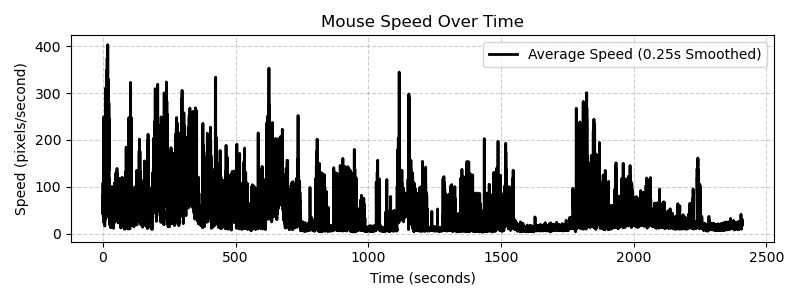

In [7]:
# --- Calculate Average Displacement and Speed ---

time_per_frame = 1.0 / frame_rate # seconds per frame

# Calculate speed in pixels per second
# Speed = Displacement of Median Point (pixels/frame) * Frame Rate (frames/second)
speed_pixels_per_second = df_dlc[('analysis', 'displacement_median_pixels')] * frame_rate

# --- Add results to the main DataFrame ---
# Remove the old 'average_displacement_pixels' column if it exists to avoid confusion
if ('analysis', 'average_displacement_pixels') in df_dlc.columns:
    df_dlc = df_dlc.drop(columns=[('analysis', 'average_displacement_pixels')])

df_dlc[('analysis', 'speed_pixels_per_second')] = speed_pixels_per_second

# Sort columns for potentially better readability (optional)
df_dlc = df_dlc.sort_index(axis=1)

print("\nMain DataFrame with Median-Derived Speed columns added:")
# Display head focusing on new columns
if all(col in df_dlc.columns for col in [('analysis', 'median_x'), ('analysis', 'median_y'), ('analysis', 'displacement_median_pixels'), ('analysis', 'speed_pixels_per_second')]):
    print(df_dlc[[('analysis', 'median_x'), ('analysis', 'median_y'), ('analysis', 'displacement_median_pixels'), ('analysis', 'speed_pixels_per_second')]].head())
else:
    print(df_dlc.head())


# Display summary statistics for the calculated speed
print("\nSpeed Summary Statistics (pixels/second) - Median Based:")
# Check if the speed column exists before describing
if ('analysis', 'speed_pixels_per_second') in df_dlc.columns:
    print(df_dlc[('analysis', 'speed_pixels_per_second')].describe())
else:
    print("Speed column ('analysis', 'speed_pixels_per_second') not found.")

# --- Save the DataFrame with the speed column ---

# Define the subdirectory name
output_subdir = "speed_calculation"
# Create the full path for the output directory
output_dir_path = os.path.join(input_dir, output_subdir)

# Create the subdirectory if it doesn't exist
os.makedirs(output_dir_path, exist_ok=True)
print(f"\nEnsured output directory exists: {output_dir_path}")

base_name_without_ext = os.path.splitext(file_name)[0]
# Add '_all' suffix if the initial bodyparts_for_calculation list was empty
if calculation_mode == 'all':
    suffix = '_all_avg_speed'
elif calculation_mode == 'default':
    suffix = '_default_avg_speed'
elif calculation_mode == 'custom':
    if not final_bodyparts_list: # Should not happen due to check above, but safe
         print("Warning: Custom mode selected but final_bodyparts_list is empty.")
    elif len(final_bodyparts_list) == 1:
        parts_suffix = final_bodyparts_list[0]
        suffix = f'_{parts_suffix}_avg_speed'
    elif len(final_bodyparts_list) == 2:
        parts_suffix = '_'.join(final_bodyparts_list)
        suffix = f'_{parts_suffix}_avg_speed'
    else: # 3 or more parts
        parts_suffix = '_'.join(final_bodyparts_list[:2]) + '_etc'
        suffix = f'_{parts_suffix}_avg_speed'
else:
     print(f"Warning: Unknown calculation_mode '{calculation_mode}'. Using fallback suffix.")
# --- End suffix generation ---

base_output_name = base_name_without_ext + suffix
output_filename_csv = os.path.join(output_dir_path, base_output_name + '.csv')


# Save the DataFrame
try:
    df_dlc.to_csv(output_filename_csv)
    print(f"DataFrame with median-derived speed saved to: {output_filename_csv}")
except Exception as e:
    print(f"Error saving CSV file: {e}")

if create_plots:
    # Since df_displacements (for individual parts) is no longer calculated in the previous cell,
    # we pass an empty DataFrame for it. The plot_speed function's 'Average Speed'
    # will use the new median-derived speed_pixels_per_second from df_dlc.
    # Set plot_individual=False as individual part displacements are not available here.
    empty_df_displacements = pd.DataFrame(index=df_dlc.index)

    plot_speed(df_dlc=df_dlc,
               df_displacements=empty_df_displacements, # Pass empty df
               final_bodyparts_list=final_bodyparts_list, # Still useful for context
               frame_rate=frame_rate,
               output_dir=output_dir_path,
               base_filename=base_output_name,
               plot_individual=False, # Set to False as individual displacements are not passed
               save_plot=save_plots,
               smoothing_window_seconds=smoothing_window_seconds)
else:
    print("\nPlotting is disabled (create_plots=False).")

In [ ]:
# --- Cell for Creating Synchronized Video ---

# Only run if video file was found and create_synced_video is True
if create_synced_video and 'df_dlc' in locals() and ('analysis', 'speed_pixels_per_second') in df_dlc.columns:
    print("\n--- Starting Synchronized Video Generation ---")

   

    # Define output video path
    video_output_filename = base_output_name + '_synced_video.mp4'
    output_video_path = os.path.join(output_dir_path, video_output_filename)

    # --- Prepare Smoothed Speed Data ---
    # Calculate smoothing window in frames
    if smoothing_window_seconds > 0:
        smoothing_window_frames = int(smoothing_window_seconds * frame_rate)
        if smoothing_window_frames < 1:
            smoothing_window_frames = 1
        print(f"Calculating smoothed speed with window: {smoothing_window_frames} frames ({smoothing_window_seconds}s)")
        # Use rolling average on the speed column
        # center=False aligns the window to the right (causal smoothing)
        # min_periods=1 ensures output even at the beginning
        smoothed_speed = df_dlc[('analysis', 'speed_pixels_per_second')].rolling(window=smoothing_window_frames, min_periods=1, center=False).mean()
    else:
        # ...
        smoothed_speed = df_dlc[('analysis', 'speed_pixels_per_second')]
        # ...

    # --- Prepare Median Coordinates for Overlay ---
    median_coords_for_video = None
    if ('analysis', 'median_x') in df_dlc.columns and \
       ('analysis', 'median_y') in df_dlc.columns:
        median_coords_for_video = df_dlc[[('analysis', 'median_x'), ('analysis', 'median_y')]]
    else:
        print("Warning: Median coordinate columns not found in df_dlc. Median point overlay will be skipped.")


    # Call the video creation function
    create_synced_video_with_plot(
        video_path=video_file_path,
        speed_data=smoothed_speed,
        frame_rate=frame_rate,
        output_video_path=output_video_path,
        median_coords=df_dlc[[('analysis', 'median_x'), ('analysis', 'median_y')]], # Pass the median coordinates
        plot_width_seconds=5.0,
        plot_height_pixels=200,
        median_point_radius=5, 
        median_point_color=(255,0,0) 
    )
  
elif not create_synced_video:
    print("\nSkipping synchronized video generation because 'create_synced_video' is False or video file was not found.")
else:
    print("\nSkipping synchronized video generation: Prerequisite data ('df_dlc' or speed column) not available.")


## Sleep Phase Analysis

This section aims to identify periods where the animal is likely sleeping based on sustained low movement. We will then analyze these sleep bouts for changes in arousal.

**Approach for Identifying Sleep Bouts:**
1.  Define a **speed threshold** below which the animal is considered to be in a low-activity state.
2.  Define a **minimum duration** for which this low-activity state must be maintained to be classified as a sleep bout.
3.  Apply these criteria to the smoothed speed data to identify the start and end times of each sleep bout.

In [ ]:
sleep_speed_threshold_pixels_per_second = 75.0  
min_sleep_duration_seconds = 10
if 'smoothed_speed' not in locals():
    # Fallback: Recalculate smoothed_speed if not found (e.g., if video cell was skipped)
    print("Warning: 'smoothed_speed' not found. Recalculating based on 'smoothing_window_seconds'...")
    if smoothing_window_seconds > 0:
        smoothing_window_frames = int(smoothing_window_seconds * frame_rate)
        if smoothing_window_frames < 1: smoothing_window_frames = 1
        smoothed_speed = df_dlc[('analysis', 'speed_pixels_per_second')].rolling(
            window=smoothing_window_frames, min_periods=1, center=False
        ).mean()
        print(f"Recalculated smoothed speed with window: {smoothing_window_frames} frames.")
    else:
        smoothed_speed = df_dlc[('analysis', 'speed_pixels_per_second')]
        print("Using unsmoothed speed as smoothing_window_seconds is 0.")
else:
    print("'smoothed_speed' data found and will be used for sleep analysis.")


In [ ]:
is_low_activity = smoothed_speed < sleep_speed_threshold_pixels_per_second

# 2. Identify contiguous blocks of low activity
#    A change from False to True is a start, True to False is an end.
#    We can find groups of consecutive True/False values.
activity_groups = is_low_activity.ne(is_low_activity.shift()).cumsum()
low_activity_periods = is_low_activity[is_low_activity] # Filter for only True (low activity) periods

sleep_bouts = []
if not low_activity_periods.empty:
    for group_id, group_data in low_activity_periods.groupby(activity_groups[is_low_activity]):
        start_frame = group_data.index[0]
        end_frame = group_data.index[-1]
        
        # Calculate duration in frames and seconds
        duration_frames = (end_frame - start_frame) + 1 # Inclusive
        duration_seconds = duration_frames / frame_rate
        
        if duration_seconds >= min_sleep_duration_seconds:
            start_time_seconds = start_frame / frame_rate
            end_time_seconds = (end_frame + 1) / frame_rate # End time is exclusive for slicing later
            
            sleep_bouts.append({
                'start_frame': start_frame,
                'end_frame': end_frame,
                'start_time_s': start_time_seconds,
                'end_time_s': end_time_seconds,
                'duration_s': duration_seconds,
                'avg_speed_in_bout': smoothed_speed.loc[start_frame:end_frame].mean(),
                'max_speed_in_bout': smoothed_speed.loc[start_frame:end_frame].max()
            })

df_sleep_bouts = pd.DataFrame(sleep_bouts)

if not df_sleep_bouts.empty:
    print(f"\nIdentified {len(df_sleep_bouts)} sleep bout(s) meeting the criteria:")
    print(df_sleep_bouts[['start_time_s', 'end_time_s', 'duration_s', 'avg_speed_in_bout', 'max_speed_in_bout']].to_string())
else:
    print("\nNo sleep bouts identified meeting the specified criteria.")
    print("Consider adjusting 'sleep_speed_threshold_pixels_per_second' or 'min_sleep_duration_seconds'.")

if create_plots and not df_sleep_bouts.empty:
    fig, ax = plt.subplots(figsize=(15, 5))
    
    # Plot the smoothed speed
    time_axis_seconds = smoothed_speed.index / frame_rate
    ax.plot(time_axis_seconds, smoothed_speed, label='Smoothed Speed', color='grey', alpha=0.7, lw=1)
    
    # Plot the raw speed for comparison (can be noisy)
    # raw_speed_time_axis = df_dlc.index / frame_rate
    # ax.plot(raw_speed_time_axis, df_dlc[('analysis', 'speed_pixels_per_second')], label='Raw Speed', color='lightblue', alpha=0.5, lw=0.5)

    # Highlight sleep bouts
    for _, bout in df_sleep_bouts.iterrows():
        ax.axvspan(bout['start_time_s'], bout['end_time_s'], color='palegreen', alpha=0.4, label='Sleep Bout' if _ == 0 else "") # Label only once

    ax.axhline(sleep_speed_threshold_pixels_per_second, color='r', linestyle='--', lw=1, label=f'Sleep Threshold ({sleep_speed_threshold_pixels_per_second} px/s)')
    
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Speed (pixels/second)")
    ax.set_title("Animal Speed with Identified Sleep Bouts")
    
    # Improve legend uniqueness
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    
    ax.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    
    if save_plots:
        plot_filename = os.path.join(output_dir_path, base_output_name + '_sleep_bouts.png')
        try:
            plt.savefig(plot_filename, dpi=300)
            print(f"\nSleep bouts plot saved to: {plot_filename}")
        except Exception as e:
            print(f"Error saving sleep bouts plot: {e}")
    
    plt.show()
elif not create_plots:
    print("\nPlotting is disabled (create_plots=False).")
elif df_sleep_bouts.empty and create_plots:
    print("\nNo sleep bouts to plot.")

In [ ]:
# --- Cell for Creating Synchronized Video with Sleep Analysis ---

# Set to False to skip video generation
generate_sleep_analysis_video = True  

if generate_sleep_analysis_video and 'df_dlc' in locals() and ('analysis', 'speed_pixels_per_second') in df_dlc.columns:
    print("\n--- Starting Synchronized Video Generation with Sleep Analysis ---")

    # Define output video path for sleep analysis video (different name than the regular synced video)
    video_output_filename = base_output_name + '_sleep_analysis_video.mp4'
    output_video_path = os.path.join(output_dir_path, video_output_filename)

    # Check if smoothed_speed is already calculated
    if 'smoothed_speed' not in locals():
        # Calculate smoothing window in frames
        if smoothing_window_seconds > 0:
            smoothing_window_frames = int(smoothing_window_seconds * frame_rate)
            if smoothing_window_frames < 1:
                smoothing_window_frames = 1
            print(f"Calculating smoothed speed with window: {smoothing_window_frames} frames ({smoothing_window_seconds}s)")
            # Use rolling average on the speed column
            smoothed_speed = df_dlc[('analysis', 'speed_pixels_per_second')].rolling(window=smoothing_window_frames, min_periods=1, center=False).mean()
        else:
            smoothed_speed = df_dlc[('analysis', 'speed_pixels_per_second')]

    # Check if df_sleep_bouts exists and is not empty
    if 'df_sleep_bouts' not in locals() or df_sleep_bouts.empty:
        print("Warning: No sleep bouts found. The video will not show any sleep periods.")
        sleep_bouts_for_video = pd.DataFrame()
    else:
        sleep_bouts_for_video = df_sleep_bouts
        print(f"Using {len(sleep_bouts_for_video)} identified sleep bouts for visualization.")

    # Call the video creation function with sleep analysis
    try:
        create_synced_video_with_sleep_analysis(
            video_path=video_file_path,
            speed_data=smoothed_speed,
            frame_rate=frame_rate,
            output_video_path=output_video_path,
            df_sleep_bouts=sleep_bouts_for_video,  # Pass the sleep bouts DataFrame
            median_coords=df_dlc[[('analysis', 'median_x'), ('analysis', 'median_y')]],
            plot_width_seconds=5.0,
            plot_height_pixels=200,
            median_point_radius=5,
            median_point_color=(255, 0, 0),  # Red in BGR
            sleep_threshold=sleep_speed_threshold_pixels_per_second,
            arousal_low_threshold=30.0,
            arousal_high_threshold=40.0
        )
        print(f"Sleep analysis video created at: {output_video_path}")
    except Exception as e:
        print(f"Error creating sleep analysis video: {e}")
        import traceback
        traceback.print_exc()

elif not generate_sleep_analysis_video:
    print("\nSkipping sleep analysis video generation (generate_sleep_analysis_video=False)")
else:
    print("\nSkipping sleep analysis video generation: Required data not available.")